In [ ]:
%run setup_Sv_compute.ipynb

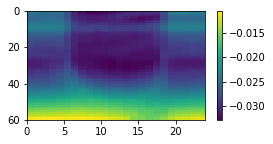

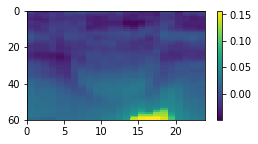

In [199]:
for ieof in np.arange(0,2): 
    uf = u[:,ieof].reshape((24,60))
    fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(4,2))
    pc = ax.pcolormesh(uf.transpose())
    ax.set_ylim([60,0])
    plt.colorbar(pc, ax=ax)

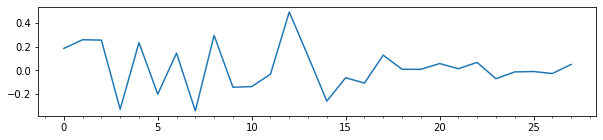

In [204]:
from matplotlib.ticker import AutoMinorLocator
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10,2))
ax.plot(v[:,0])
ax.xaxis.set_minor_locator(AutoMinorLocator())

In [ ]:
%run fxns_Sv_compute.ipynb

In [ ]:
import matplotlib.dates as mdates

In [ ]:
dfnow = df[df['geo_region'].notnull()]
dfnow = dfnow[dfnow['geo_region'].str.contains('acific')]

In [ ]:
fnamesnow = dfnow['fname'].values

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/opt/conda/lib/python3.7/site-packages/xarray/core/computa

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

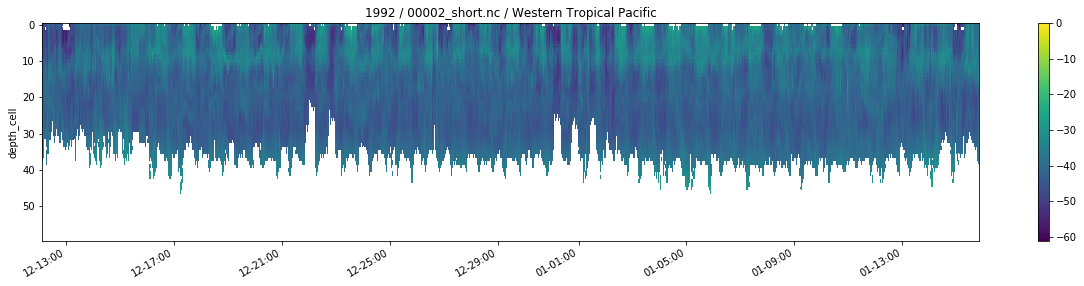

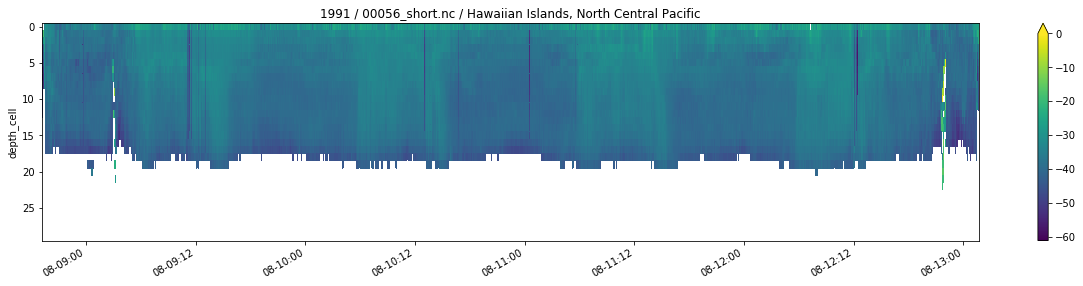

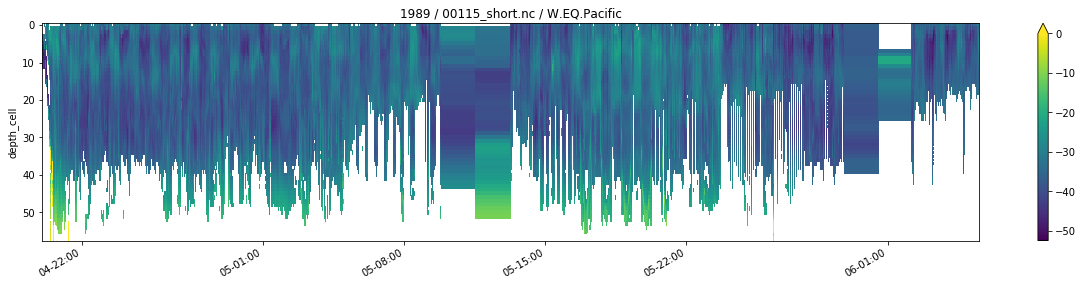

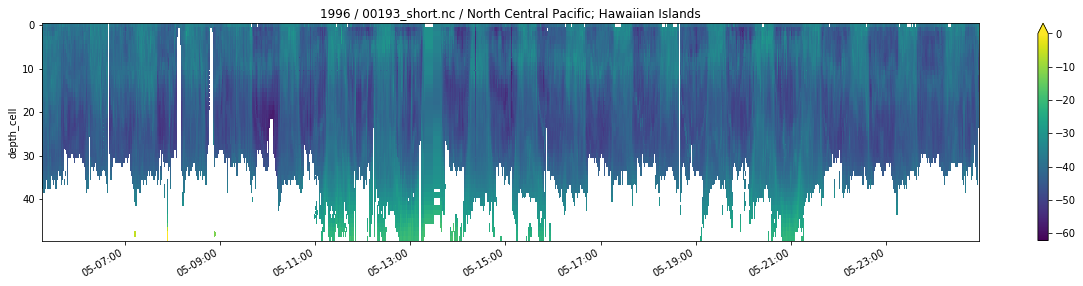

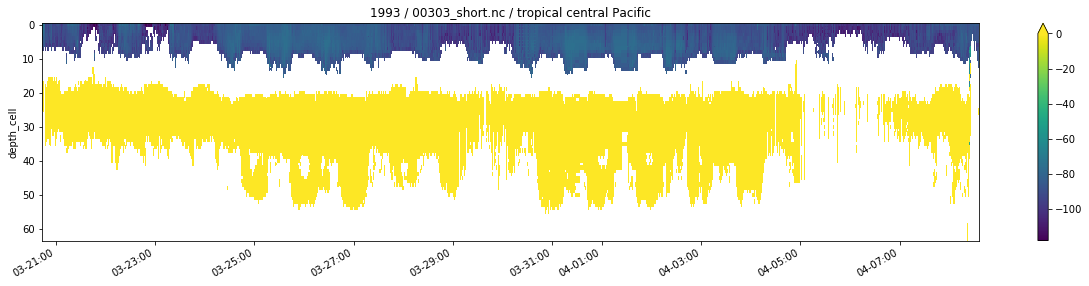

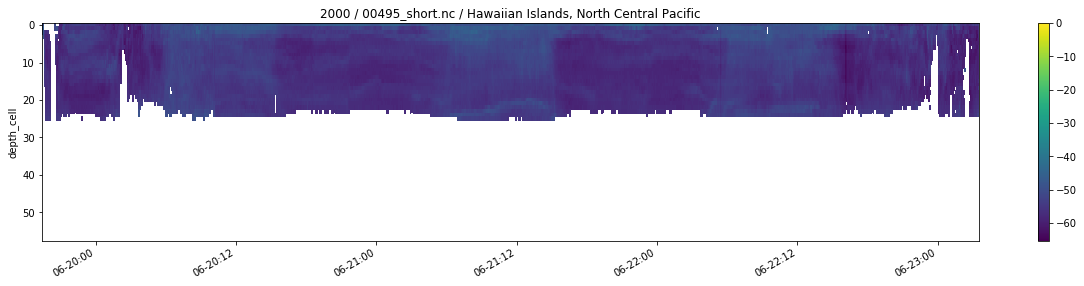

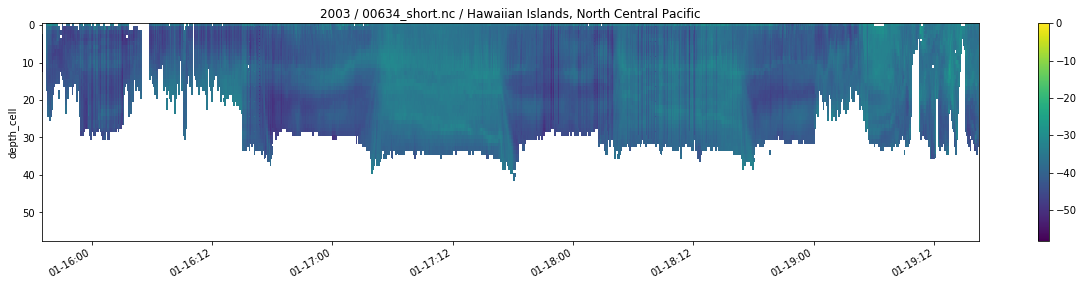

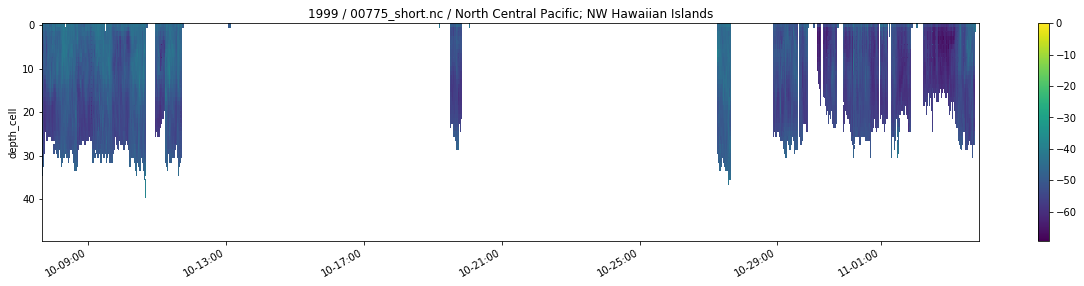

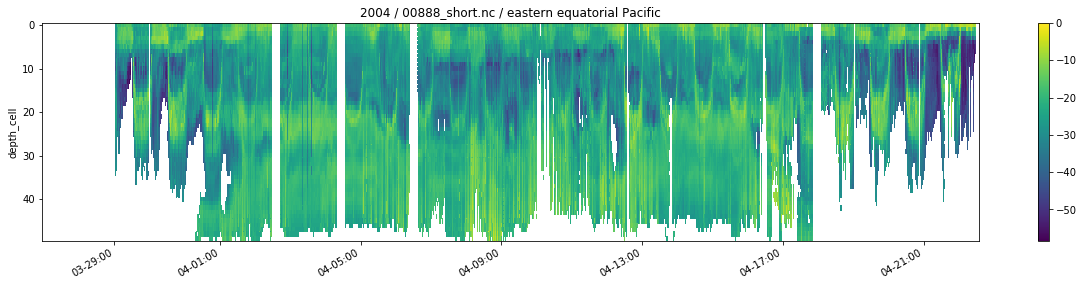

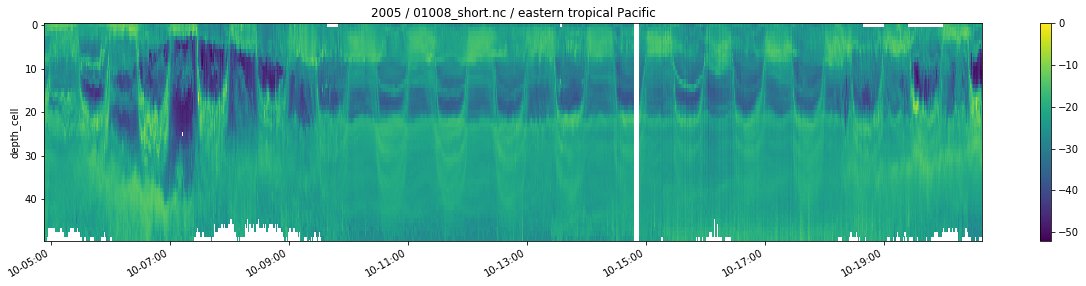

In [107]:
#fname = '00890_short.nc' # --> Sv computation works for this! Uses OS, in central eq pac
#fname = '00111_short.nc' # --> Sv computation works for this! Uses NB-VM-150, in w eq pac
for fname in fnamesnow[np.floor(np.linspace(1,1273,25)).astype(int)]:
    ncfile = dpath + 'JASADCP/ncfiles/' + fname
    nc = xr.open_dataset(ncfile)

    amp = nc['amp']
    Tx = nc['tr_temp']
    depth = nc['depth']
    row = df[df['fname']==fname].iloc[0]
    # - no bandwidth for a file; pretend it's narrowband for now
    if row['bandwidth']==None:
        row['bandwidth']='narrowband'
    
    Er = get_Er_constant(row,amp)
    #print('Er: ',Er)
    
    if 'NB' not in row['instrument_name']:
        Kc = get_Kc_constant(row)
    elif 'NB' in row['instrument_name']:
        Kc = get_Kc_tdresolved(row,amp,Tx)
    #print('Kc: ',Kc)
    
    LDBM = get_LDBM_constant(row)
    #print('LDBM: ',LDBM)
    
    if 'NB' not in row['instrument_name']:
        PDBW = get_PDBW_constant(row)
    elif 'NB' in row['instrument_name']:
        #PDBW = get_PDBW_tdresolved(row)
        PDBW = get_PDBW_constant(row)
    #print('PDBW: ',PDBW)
    
    R = get_R_tdresolved(row, depth, method_num=5)
    #print('R: ',R)
    
    c = calc_c_tdresolved(depth,T=25,S=35)
    #print('c: ',c)
    
    if 'NB' not in row['instrument_name']:
        C = get_C_constant(row)
    elif 'NB' in row['instrument_name']:
        C = get_C_tdresolved(row,c)
    #print('C: ',C)
    
    Tnow = depth.copy(deep=True); Tnow.name = 'temperature'; Tnow[:,:] = 25
    alpha = calc_alpha_tdresolved(row,depth,c,Tnow,S=35,pH=8.1)
    #print('alpha: ',alpha)
    
    alphaR = calc_alphaR_tdresolved(alpha,R)
    #print('alphaR: ',alphaR)
    
    Sv = C + 10*np.log10((Tx+273.16)*R**2) - LDBM + PDBW \
        + 2*alphaR + 10*np.log10(10**(Kc*(amp-Er)/10) - 1)
    
    Sv_pf = nc['pflag'].copy(deep=True)
    Sv_pg = nc['pg'].copy(deep=True)
    
    fig,axes = plt.subplots(nrows=1, ncols=1, figsize=(21,4))
    daynum0 = row['cruise_beg_date'].day
    #for isp in np.arange(0,4):
    Sv.where((Sv_pf==0) & (Sv_pg>60)).plot(ax=axes, y='depth_cell', vmax=0, yincrease=False)
    axes.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
    #axes[isp].set_xlim(['2004-05-'+str(daynum),'2004-05-'+str(daynum+3)])
    #axes[isp].set_ylim([40,0])
    #axes[isp].set_xticks(np.arange('2004-05-'+str(daynum), '2004-05-'+str(daynum+3), dtype='datetime64[h]')[0::6])
    #axes[isp].set_title(str(pd.to_datetime(Sv.time[0].values).year) + ', ' + fname)
    axes.set_title(str(row['cruise_beg_date'].year) + ' / ' + fname + ' / ' + row['geo_region'])
    axes.set_xlabel('')
    fig.savefig(figpath + os.path.splitext(fname)[0] + '_Sv.png', bbox_inches='tight', pad_inches = 0, dpi = 200)